In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

2024-04-04 20:49:48.877496: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 20:49:48.914948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-04-04 20:49:50.344831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:49:50.353448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:49:50.353488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
# We will be using a smaller vesion of the Speech Commands dataset.

# Create a new dir to extract the smaller speech command datasets
# DATASET_PATH = 'data/mini_speech_commands'
DATASET_PATH = 'data/micro_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != '.ipynb_checkpoints')]
print("Available commands: ", commands)

Available commands:  ['yes' 'right' 'no' 'left' 'stop']


In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Using 1000 files for validation.


2024-04-04 20:49:50.832727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:49:50.832836: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:49:50.832851: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:49:51.008982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 20:49:51.009049: I external/local_xla/xla/stream_executor


label names: ['left' 'no' 'right' 'stop' 'yes']


In [7]:
# Shape is now (batch, samples, channels)
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
# This dataset only uses single channel audio so we can drop the extra axis

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
# use dataset.shard to split the validations into two halves

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2024-04-04 20:49:51.952341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
    
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

In [12]:
# Testing the data

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
# Function to generate a plot of the spectogram for us to visualize

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [14]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

Build and train

In [17]:
# Adding dataset.cahce and prefect to reduce read latency

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [18]:
# Assuming input_shape and num_labels are defined as in your original setup
# Let's assume a further reduced input size if feasible
input_shape = example_spectrograms.shape[1:]

num_labels = 5  # Since we're only focusing on  ['yes' 'right' 'no' 'left' 'stop'] 

# Instantiate the tf.keras.layers.Normalization layer.
norm_layer = layers.Normalization()
# Assuming train_spectrogram_ds is defined as in your original setup
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Consider reducing input size if not already minimal
    layers.Resizing(16, 16),  # Further reduced from 32, 32
    norm_layer,
    # Simplifying to one Convolutional layer
    layers.Conv2D(16, 3, activation='relu'),  # Keep this layer simple
    layers.MaxPooling2D(),
    layers.Flatten(),
    # Further simplifying Dense layer
    layers.Dense(32, activation='relu'),  # Reduced units from 64 to 32
    layers.Dense(num_labels),
])

model.summary()

2024-04-04 20:49:53.296004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 16, 16, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,448 (99.41 KB)

 Trainable params: 25,445 (99.39 KB)

 Non-trainable params: 3 (16.00 B)

In [19]:
# Configure the Keras model with the Adam optimizer and the cross-entropy loss:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [20]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15


I0000 00:00:1712263794.251786    3775 service.cc:145] XLA service 0x7f4354020ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712263794.251916    3775 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-04-04 20:49:54.270136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-04 20:49:54.353246: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


40/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2457 - loss: 1.6153

I0000 00:00:1712263795.478750    3775 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2899 - loss: 1.5804 - val_accuracy: 0.4652 - val_loss: 1.3786
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5279 - loss: 1.2657 - val_accuracy: 0.5676 - val_loss: 1.1830
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6201 - loss: 1.0671 - val_accuracy: 0.6209 - val_loss: 1.0596
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6540 - loss: 0.9345 - val_accuracy: 0.6475 - val_loss: 0.9862
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6939 - loss: 0.8721 - val_accuracy: 0.6906 - val_loss: 0.9070
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7249 - loss: 0.7797 - val_accuracy: 0.6967 - val_loss: 0.8792
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7417 - loss: 0.7184 - val_accuracy: 0.6967 - val_loss: 0.8493
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7599 - loss: 0.6892 - val_accuracy: 0.7336 - val_loss: 0.7846
Ep

Text(0, 0.5, 'Accuracy [%]')

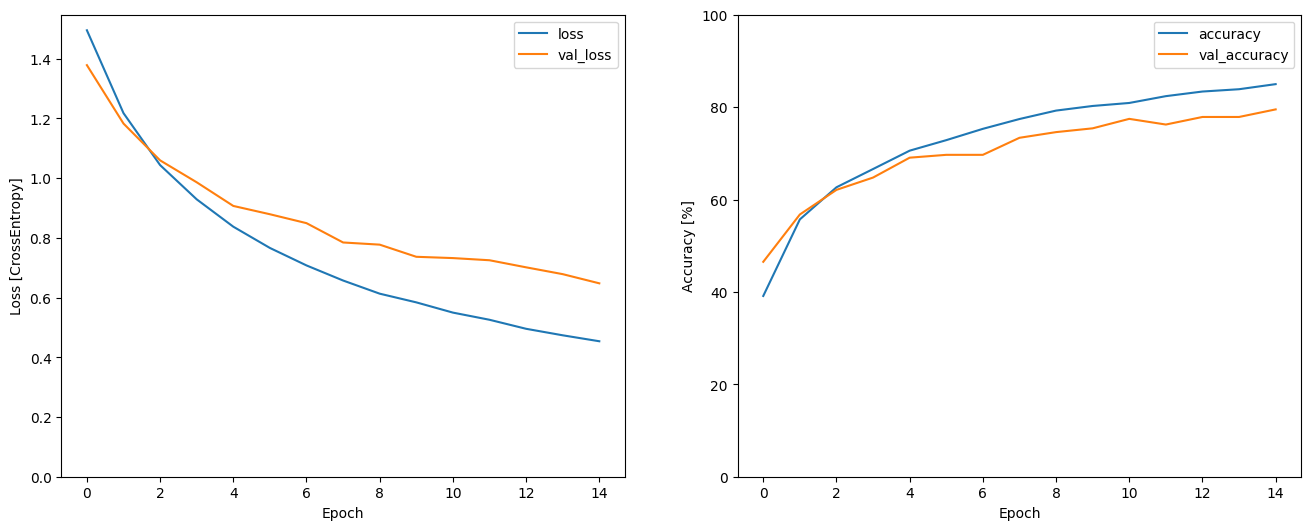

In [21]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [22]:
# Evaluate the model performance

model.evaluate(test_spectrogram_ds, return_dict=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7914 - loss: 0.6706 


{'accuracy': 0.80078125, 'loss': 0.6368218064308167}

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


2024-04-04 20:50:00.162083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


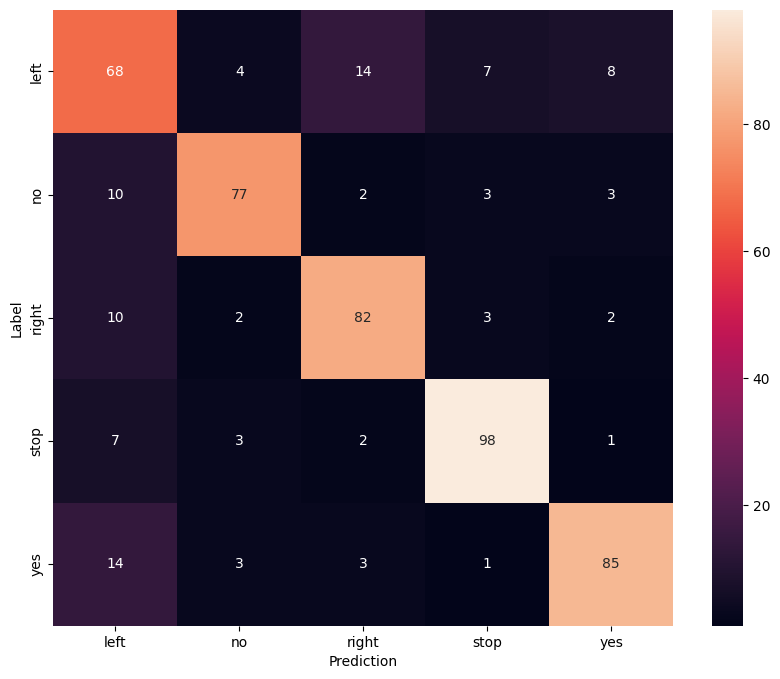

In [23]:
# Confusion Matrix

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

tf.Tensor([-0.26584017  2.8914511  -0.28268746 -0.56408936 -0.8889486 ], shape=(5,), dtype=float32)


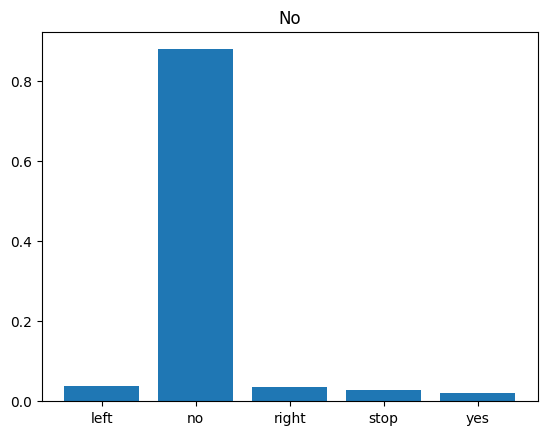

In [24]:
x = data_dir/'no/01bb6a2a_nohash_0.wav' #NO TEST
# x = data_dir/'right/012c8314_nohash_1.wav' #RIGHT TEST

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
print(prediction[0])

# x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
x_labels = ['left', 'no', 'right', 'stop', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Export

In [25]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [26]:
# Test running the export model
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.26584017,  2.8914511 , -0.28268746, -0.56408936, -0.8889486 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [ ]:
# Check the input and output tensors
input_tensors = export.__call__.get_concrete_function(x=tf.TensorSpec(shape=(), dtype=tf.string)).inputs
output_tensors = export.__call__.get_concrete_function(x=tf.TensorSpec(shape=(), dtype=tf.string)).outputs

print("Input tensors:", input_tensors)
print("Output tensors:", output_tensors)



# Convert the model again
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('ligther_model.tflite', 'wb') as f:
  f.write(tflite_model)

Input tensors: [<tf.Tensor 'x:0' shape=() dtype=string>, <tf.Tensor 'sequential_1/normalization_1/Sub/y:0' shape=(1, 1, 1, 1) dtype=float32>, <tf.Tensor 'sequential_1/normalization_1/Sqrt/x:0' shape=(1, 1, 1, 1) dtype=float32>, <tf.Tensor 'sequential_1/conv2d_1/convolution/ReadVariableOp/resource:0' shape=() dtype=resource>, <tf.Tensor 'sequential_1/conv2d_1/Reshape/ReadVariableOp/resource:0' shape=() dtype=resource>, <tf.Tensor 'sequential_1/dense_1/Cast/ReadVariableOp/resource:0' shape=() dtype=resource>, <tf.Tensor 'sequential_1/dense_1/add/ReadVariableOp/resource:0' shape=() dtype=resource>, <tf.Tensor 'sequential_1/dense_1_2/Cast/ReadVariableOp/resource:0' shape=() dtype=resource>, <tf.Tensor 'sequential_1/dense_1_2/add/ReadVariableOp/resource:0' shape=() dtype=resource>]
Output tensors: [<tf.Tensor 'Identity:0' shape=(1,) dtype=int64>, <tf.Tensor 'Identity_1:0' shape=(1,) dtype=string>, <tf.Tensor 'Identity_2:0' shape=(1, 5) dtype=float32>]
INFO:tensorflow:Assets written to: /tmp

INFO:tensorflow:Assets written to: /tmp/tmpxa0mqkqr/assets
